# Biweekly Report 5

# Jake Watts

# Transfer Learning

In the paper "How transferable are features in deep neural networks?" (https://arxiv.org/pdf/1411.1792.pdf), the authors state that "that initializing a network with transferred features from almost any number of layers can produce a boost to generalization that lingers even after fine-tuning to the target dataset.

For this report I wanted to test whether transfer learning helps in training a new network using weights from a previously trained model. I will use the model from the last report and test whether starting the training with pre-trained weights improves performance over starting with randomly initialized weights.

Last report I trained the model on Cifar-10 data and this report I will train on SVHN data which stands for street view house numbers. This dataset contains 73,257 training images and 26,032 testing images of pictures of house numbers from the street. The shape of this data is the same as Cifar-10 however the images are quite different as they are all numbers rather than objects so I am curious to see if transfer learning helps in this case.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import SeparableConv2D, ReLU, ELU
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from keras.datasets import cifar10, mnist
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

Loading in the data from tensorflow datasets. This dataset is in a different format from Keras datasets and it took a bit of time looking at documentation and tutorials to figure out how to process it for training.

In [ ]:
(train, test), info = tfds.load('svhn_cropped', 
                        split = ['train', 'test'],
                        with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteBDYM9B/svhn_cropped-train.tfrecord


  0%|          | 0/73257 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteBDYM9B/svhn_cropped-test.tfrecord


  0%|          | 0/26032 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteBDYM9B/svhn_cropped-extra.tfrecord


  0%|          | 0/531131 [00:00<?, ? examples/s]

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.


The dimension of the dataset is 32x32 pixels with 3 channels which is the same as Cifar-10.

In [ ]:
train

<PrefetchDataset shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

The dataset is also stored in a dictionary format whether the image and label and paired together.

In [ ]:
list(train)[0]

{'image': <tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
 array([[[126, 138, 136],
         [128, 138, 137],
         [129, 139, 138],
         ...,
         [ 19,  19,  19],
         [ 19,  21,  20],
         [ 19,  21,  20]],
 
        [[127, 139, 137],
         [127, 139, 137],
         [129, 140, 138],
         ...,
         [ 19,  21,  20],
         [ 19,  21,  20],
         [ 17,  21,  20]],
 
        [[128, 140, 139],
         [127, 139, 138],
         [128, 138, 137],
         ...,
         [ 19,  21,  20],
         [ 20,  22,  21],
         [ 17,  21,  20]],
 
        ...,
 
        [[ 91,  89,  96],
         [ 76,  75,  83],
         [ 69,  68,  77],
         ...,
         [ 94,  96,  91],
         [ 68,  70,  65],
         [ 43,  45,  42]],
 
        [[ 81,  78,  87],
         [ 70,  68,  78],
         [ 66,  65,  76],
         ...,
         [ 99, 100,  95],
         [ 73,  75,  70],
         [ 48,  48,  46]],
 
        [[ 73,  70,  79],
         [ 66,  64,  74],
       

Looking at 16 images from the dataset we can see the street view numbers that we want to train the model to rcognize. The most important number is the number in the center as that each label only contains one number. I think that this might make it harder in instances in which there are three numbers shown such as house number 680 where the model only needs to pay attention to the 8.

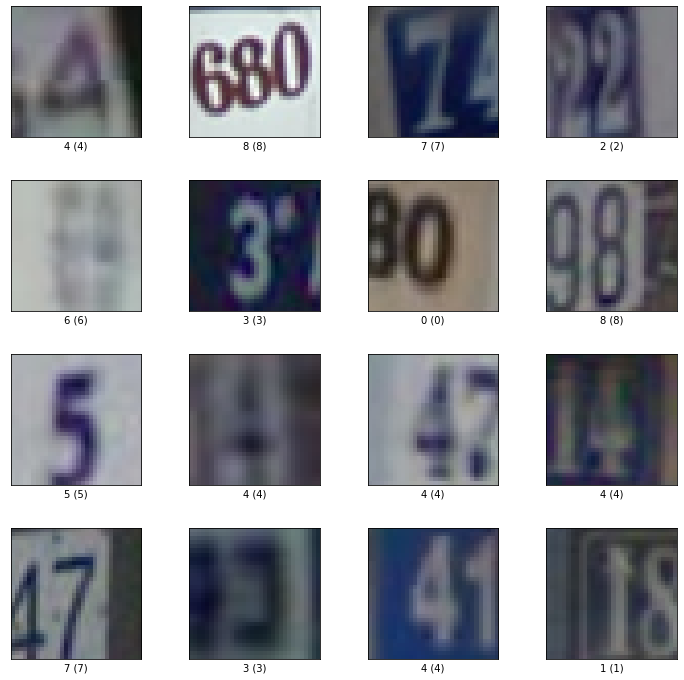

In [ ]:
fig = tfds.show_examples(train, ds_info = info, rows = 4, cols = 4)

Here I create a function to normalize data and one-hot encode the training and testing images and labels.

In [ ]:
def normalize_img(datapoint):
  input_image = tf.cast(datapoint['image'], tf.float32) / 255.0
  input_label = tf.one_hot(datapoint['label'], 10)
  return input_image, input_label

I apply the function to the data using the map function.

In [ ]:
  train_img = train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
  test_img = test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

Setting hyper-parameters for training.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Defining the training batches, this is a lot different than how I had to do this for the cifar-10 data.

In [ ]:
train_batches = (
    train_img
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_img.batch(BATCH_SIZE)

Mounting Google Drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading my model trained on Cifar-10 data.

In [ ]:
model = load_model('/content/gdrive/My Drive/cifar10_xception_aug.h5')

Defining callbacks for training.

In [ ]:
filepath = '/content/gdrive/My Drive/svhn_xception_tl.h5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10)

callbacks = [checkpoint, lr_reducer, es]

Time to train the model with the initial weights from the trained Cifar-10 model.

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=callbacks)

Epoch 1/20
1144/1144 [==============================] - 20s 17ms/step - loss: 1.1920 - accuracy: 0.6389 - val_loss: 0.6534 - val_accuracy: 0.7907

Epoch 00001: val_loss improved from inf to 0.65340, saving model to /content/gdrive/My Drive/svhn_xception_tl.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
1144/1144 [==============================] - 19s 17ms/step - loss: 0.5183 - accuracy: 0.8378 - val_loss: 0.4659 - val_accuracy: 0.8544

Epoch 00002: val_loss improved from 0.65340 to 0.46591, saving model to /content/gdrive/My Drive/svhn_xception_tl.h5
Epoch 3/20
1144/1144 [==============================] - 19s 17ms/step - loss: 0.3913 - accuracy: 0.8790 - val_loss: 0.3917 - val_accuracy: 0.8821

Epoch 00003: val_loss improved from 0.46591 to 0.39167, saving model to /content/gdrive/My Drive/svhn_xception_tl.h5
Epoch 4/20
1144/1144 [==============================] - 19s 17ms/step - loss: 0.3207 - accuracy: 0.9026 - val_loss: 0.3503 - val_accuracy: 0.8954

Epoch 00004: val_loss improved from 0.39167 to 0.35030, saving model to /content/gdrive/My Drive/svhn_xception_tl.h5
Epoch 5/20
1144/1144 [==============================] - 19s 17ms/step - loss: 0.2756 - accuracy: 0.9184 - val_loss: 0.3310 - val_accuracy: 0.9010

Epoch 00005: val_loss improved from 0.35030 to 0.33101, savin

Looking at the validation accuracy we can see that the model improves quickly during the first five epochs but then seems to reach a pleateau where the accracy seems to be constant.

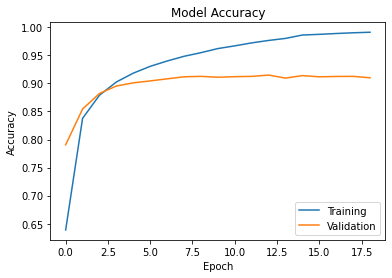

In [ ]:
plt.figure()
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

The model with initialized weights from Cifar-10 gives an accuracy of 91.31%.

In [ ]:
model.evaluate(test_batches)

407/407 [==============================] - 6s 13ms/step - loss: 0.3773 - accuracy: 0.9131


[0.37726137042045593, 0.9130685329437256]

Now I define the model again this time with weights randomly initialized rather than using an already trained model to compare.

In [ ]:
def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [ ]:
def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ELU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ELU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ELU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ELU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ELU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ELU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ELU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ELU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        tensor = Add()([tensor,x])
        
        return tensor
# exit flow

def exit_flow(tensor):
    x = GlobalAvgPool2D()(tensor)
    
    x = Dense (units = 10, activation = 'softmax')(x)
    
    return x

In [ ]:
input = Input(shape = (32,32,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)

In [ ]:
filepath = '/content/gdrive/My Drive/svhn_xception.h5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10)

callbacks = [checkpoint, lr_reducer, es]

With the model defined we can now train it starting with random weights.

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=callbacks)

Epoch 1/20
1144/1144 [==============================] - 21s 17ms/step - loss: 0.6177 - accuracy: 0.8129 - val_loss: 0.4833 - val_accuracy: 0.8532

Epoch 00001: val_loss improved from inf to 0.48332, saving model to /content/gdrive/My Drive/svhn_xception.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
1144/1144 [==============================] - 19s 17ms/step - loss: 0.3159 - accuracy: 0.9050 - val_loss: 0.3271 - val_accuracy: 0.9047

Epoch 00002: val_loss improved from 0.48332 to 0.32707, saving model to /content/gdrive/My Drive/svhn_xception.h5
Epoch 3/20
1144/1144 [==============================] - 19s 17ms/step - loss: 0.2478 - accuracy: 0.9257 - val_loss: 0.3451 - val_accuracy: 0.9024

Epoch 00003: val_loss did not improve from 0.32707
Epoch 4/20
1144/1144 [==============================] - 19s 17ms/step - loss: 0.2032 - accuracy: 0.9401 - val_loss: 0.3219 - val_accuracy: 0.9078

Epoch 00004: val_loss improved from 0.32707 to 0.32188, saving model to /content/gdrive/My Drive/svhn_xception.h5
Epoch 5/20
1144/1144 [==============================] - 19s 17ms/step - loss: 0.1715 - accuracy: 0.9489 - val_loss: 0.2781 - val_accuracy: 0.9253

Epoch 00005: val_loss improved from 0.32188 to 0.27815, saving model to /content/gdrive/My Drive/svhn_xception.h5
Epoch 6/20
1144/114

This model seems to be able to improve beyond the plateau that the was reached during the previous training.

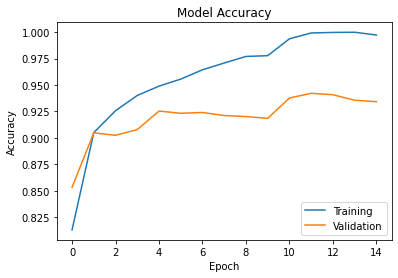

In [ ]:
plt.figure()
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

The accuracy on the testing data is 93.62% which is about two percent higher than when using the pre-trained model.

In [ ]:
model.evaluate(test_batches)

# Summary
 
I thought that using a trained model may increase the accuracy during training as some parts of the model may have been generalizable to other object classification tasks. However it appears that it did not help as the accuracy is higher for the model using random weights rather than weights from a pre-trained model.
 
My guess is that this is because of one of the problems with transfer learning outlined in the paper mentioned above. The paper specifies that specialization of higher layer neurons to the original task can impede performance in another. This makes sense as the task of optimizing to recognize the images in cifar-10 is quite different from recognizing digits. Despite the fact that starting the model with pre-trained weights does not help in this case, I do still think there could be specific layers within the trained model that would still be generalizable and therefore useful for transfer learning.
